## Mount Drive & Setup Path

In [1]:
# Cell 1 : Mount Google Drive & Setup Path Dataset
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Setup Dataset


In [2]:
# Cell 2: Load Dataset
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

# Path Dataset
dataset_path = "/content/drive/MyDrive/dataset-split"

# Parameter umum
image_size = (128, 128)
batch_size = 16

# Load masing-masing set
train_ds = image_dataset_from_directory(
    dataset_path + "/train",
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True # Agar model tidak belajar urutan gambar
)

val_ds = image_dataset_from_directory(
    dataset_path + "/val",
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

test_ds = image_dataset_from_directory(
    dataset_path + "/test",
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

# Normalisasi pixel ke [0, 1]
rescale = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Prefetch untuk efisiensi
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Found 504 files belonging to 2 classes.
Found 144 files belonging to 2 classes.
Found 72 files belonging to 2 classes.


# Fungsi Squash dan Capsule Layer


In [3]:
# Cell 3 : Fungsi Squash dan Custom Capsule Layer
from tensorflow.keras import layers
from keras.saving import register_keras_serializable

# Squash Function
@register_keras_serializable()
def squash(vectors, axis=-1):
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
    return scale * vectors

@register_keras_serializable()
def capsule_length(z):
    """Menghitung panjang vektor capsule (norm) untuk klasifikasi."""
    return tf.norm(z, axis=-1)

# Custom Capsule Layer
@register_keras_serializable()
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, dim_capsules, num_routing=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.num_routing = num_routing

    def build(self, input_shape):
        self.input_num_capsules = input_shape[1]
        self.input_dim_capsules = input_shape[2]
        self.W = self.add_weight(shape=[self.input_num_capsules, self.num_capsules, self.input_dim_capsules, self.dim_capsules],
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, inputs):
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 2), -1)  # [batch, input_caps, 1, input_dim, 1]
        W_tiled = tf.tile(tf.expand_dims(self.W, 0), [tf.shape(inputs)[0], 1, 1, 1, 1])
        u_hat = tf.matmul(W_tiled, inputs_expand)  # [batch, input_caps, num_caps, dim_caps, 1]
        u_hat = tf.squeeze(u_hat, axis=-1)  # [batch, input_caps, num_caps, dim_caps]

        b = tf.zeros_like(u_hat[:, :, :, 0])  # [batch, input_caps, num_caps]

        for i in range(self.num_routing):
            c = tf.nn.softmax(b, axis=2)
            outputs = squash(tf.reduce_sum(tf.expand_dims(c, -1) * u_hat, axis=1))

            if i < self.num_routing - 1:
                b += tf.reduce_sum(u_hat * tf.expand_dims(outputs, 1), axis=-1)

        return outputs  # [batch, num_caps, dim_caps]

# Arsitektur CapsNet

In [4]:
# Cell 4 : Arsitektur CapsNet

from tensorflow.keras import models


def build_capsnet_binary(input_shape, num_capsules=2, dim_capsules=16, num_routing=5):
    inputs = layers.Input(shape=input_shape)

    # Conv1
    x = layers.Conv2D(64, 9, strides=1, padding='valid', activation='relu')(inputs)

    # Conv2
    x = layers.Conv2D(128, 9, strides=2, padding='valid', activation='relu')(x)

    # PrimaryCaps
    x = layers.Conv2D(filters=32 * dim_capsules, kernel_size=9, strides=2, padding='valid', activation='relu')(x)
    x = layers.Reshape((-1, dim_capsules))(x)
    x = layers.Lambda(squash)(x)

    # DigitCaps
    x = CapsuleLayer(num_capsules=num_capsules, dim_capsules=dim_capsules, num_routing=num_routing)(x)

    # Magnitude (length of capsule output vector)
    out_caps = layers.Lambda(capsule_length)(x)
    output = out_caps

    model = models.Model(inputs=inputs, outputs=output)
    return model

# Kompilasi Model


In [5]:
# Cell 5 : Inisialisasi dan Kompilasi Model
input_shape = (128, 128, 3)
model = build_capsnet_binary(input_shape)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 120, 120, 64)   │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 128)    │       663,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 512)    │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 18432, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 18432, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_layer (CapsuleLayer)    │ (None, 2, 16)          │     9,437,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,425,408 (58.84 MB)

 Trainable params: 15,425,408 (58.84 MB)

 Non-trainable params: 0 (0.00 B)



# Training Model




In [6]:
# Cell 6 : Training Model

# Callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop]
)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.5317 - loss: 1.7794 - val_accuracy: 0.5000 - val_loss: 0.7032
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 343ms/step - accuracy: 0.4911 - loss: 0.7057 - val_accuracy: 0.5556 - val_loss: 0.7009
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 346ms/step - accuracy: 0.4673 - loss: 0.6992 - val_accuracy: 0.5000 - val_loss: 0.6969
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 365ms/step - accuracy: 0.4904 - loss: 0.6965 - val_accuracy: 0.5139 - val_loss: 0.6955
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 405ms/step - accuracy: 0.5191 - loss: 0.6956 - val_accuracy: 0.5694 - val_loss: 0.6928
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 354ms/step - accuracy: 0.5971 - loss: 0.6937 - val_accuracy: 0.5556 - val_loss: 0.6916
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 414ms/step - accuracy: 0.5493 - loss: 0.6932 - val_accuracy: 0.6042 - val_loss: 0.6861
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 355ms/step - accuracy: 0.5726 - loss: 0.6872 - va

In [7]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.9158 - loss: 0.3185

Test accuracy: 0.8750, Test loss: 0.3690


In [8]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

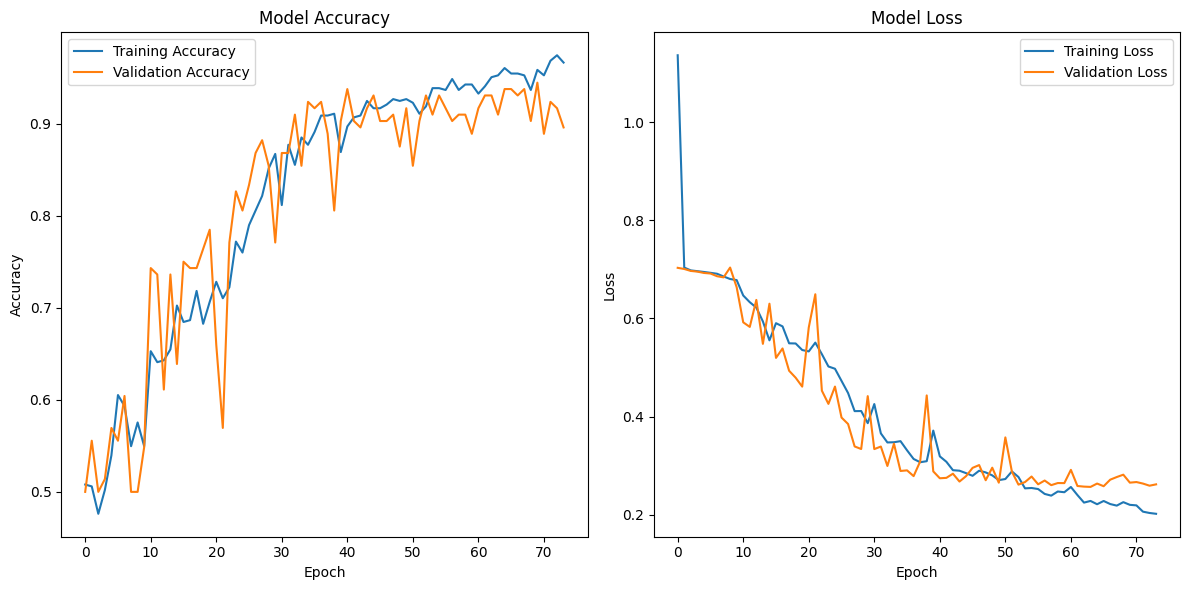

In [9]:
plot_history(history, 'Model')

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 433ms/step


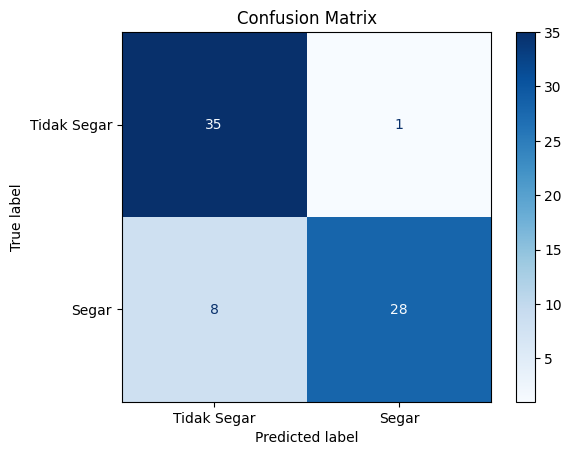

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prediksi label dari model
y_pred = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ekstrak label sebenarnya dari test_dataset
y_true = []
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Tampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Tidak Segar", "Segar"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_true, y_pred_labels)
recall = recall_score(y_true, y_pred_labels)
f1 = f1_score(y_true, y_pred_labels)
accuracy = accuracy_score(y_true, y_pred_labels)

print(f"Akurasi  : {accuracy:.4f}")
print(f"Presisi  : {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")


Akurasi  : 0.8750
Presisi  : 0.9655
Recall   : 0.7778
F1-Score : 0.8615
